Following Khomyakov's trouble-shooting tips in https://arxiv.org/pdf/cond-mat/0501609.pdf

In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

from dataclasses import dataclass
import RGF_single_orbital as so
import RGFtools as rg
@dataclass
class JosephsonParameters:
    W : int
    L : int
    a : float
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
from scipy.linalg import orth

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
params = JosephsonParameters(W = 10 , 
                             L = 10,
                             t = 1,
                             a = 1 , 
                             flux = 0.0,
                             energy = 0.5,
                             Delta = 0,
                             phase = 0,
                             mu = 0.5,
                            tol = 1e-4)



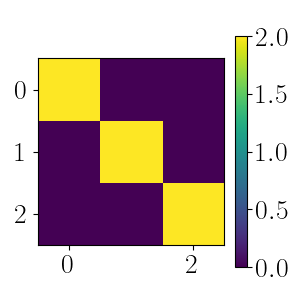

In [3]:
lead_indices = [0 , params.L + 1]
diag_greens , offdiag_greens = so.RGF_left_sweep(lead_indices , params)
transmission, unphysical =  so.transmission_matrix_left(lead_indices , diag_greens , offdiag_greens , params )
plt.figure(figsize = (3 , 3))
plt.imshow(np.abs(transmission))
plt.colorbar()

3


/var/folders/q7/mt24cx7d41b3712vq5fcskd80000gn/T/ipykernel_1323/3250347524.py:38: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable = im0)


Text(0.5, 1.0, 'Kwant')

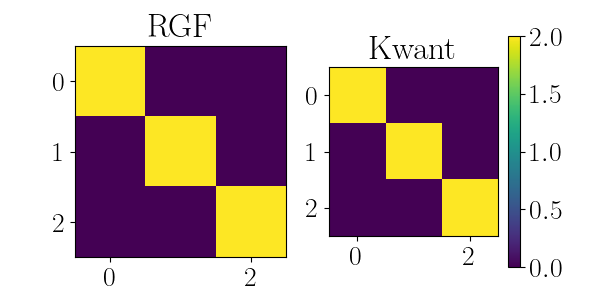

In [4]:
# Modelling the same system in Kwant for comparision:
def kwant_comparision(params):
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a , norbs = 1)

    for i in range(params.L):
        for j in range(params.W):
            syst[lat(i , j)] = 4*params.t - params.mu

            if i > 0:
                syst[lat(i , j) , lat(i-1 , j)] = -params.t
            if j > 0:
                syst[lat(i , j) , lat(i , j-1)] = -params.t

    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))
    for i in range(params.W):
        lead[lat(0 , i)] = 4*params.t - params.mu
        if i >0:
            lead[lat(0 , i) , lat(0 , i-1) ] = - params.t
        lead[lat(1 , i) , lat(0 , i)] = - params.t

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    return syst
smatrix = kwant.smatrix(kwant_comparision(params) , energy = params.energy)

num_propagating = smatrix.num_propagating

print(num_propagating(0))

t_block = smatrix.data[smatrix.block_coords(1 , 0)]

fig , ax = plt.subplots(nrows = 1 , ncols = 2)
fig.set_figheight(3)
fig.set_figwidth(6)
im0 = ax[0].imshow(np.abs(transmission))
plt.colorbar(mappable = im0)
ax[0].set_title(r'RGF')
im1 = ax[1].imshow(np.abs(t_block))
ax[1].set_title(r'Kwant')



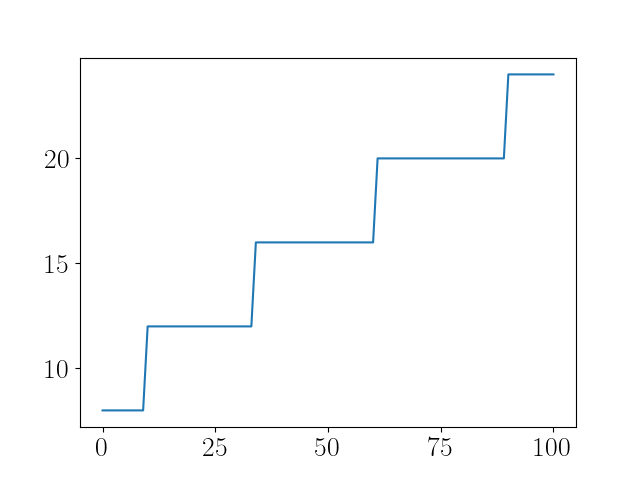

In [5]:
# Testing conductance calculation:
energy_values = np.linspace(0 , 2 , 101)
conductance_values = np.zeros(energy_values.shape[0])
transmission_matrices = []
unphysical_transmission_matrices = []
for i in range(len(energy_values)):
    params.energy = energy_values[i]
    diag_greens , offdiag_greens = so.RGF_left_sweep(lead_indices , params)
    transmission , unphysical_transmission_matrices = so.transmission_matrix_left(lead_indices , diag_greens , offdiag_greens , params )
    transmission_matrices.append(transmission)
    conductance_values[i] = np.trace(np.conjugate(transmission.T)@transmission)

plt.figure()
plt.plot(conductance_values)